# Fusion Embeddings

In [ ]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary

sys.path.append('/path/to/working/directory/workbench')
from datasets.dataset import PublicMicrobiomeDataset, ClassLabel
from models.fusion import MmFusionModel
from train_models import load_backbones_for_fusion, load_model

# Main

In [ ]:
images_path  = '/path/to/microbiome_maps/flat_all'
labels_file  = '/path/to/labels_v1.5b_joint.csv'

hfe_base_dir = '/path/to/hfe/all_datasets_combined'
hfe_features = f'{hfe_base_dir}/hfe_embeddings_512_with_ids.npz'

# Has to match what we trained with
target_factor   = ClassLabel.MULTI_LABEL
class_support   = 8
should_augment  = False
n_channels      = 3
height_width    = 256
use_hfe         = True

master_dataset = PublicMicrobiomeDataset(root_dir=images_path,
                                         csv_file=labels_file,
                                         class_support=class_support,
                                         should_augment=should_augment,
                                         height_width=height_width,
                                         target_factor=target_factor,
                                         use_hfe=use_hfe,
                                         hfe_features=hfe_features)

batch_size = 1
dl_nworkers = 0
master_dataloader = DataLoader(master_dataset, batch_size=batch_size, num_workers=dl_nworkers)

## Load Model

In [ ]:
base_models_dir = '/path/to/model/training/multi_label'

fusion_model_save_path = f'{base_models_dir}/fusion_trainable/best_models/fusion_best_model.pth'
embedding_size = 512

device = 'cpu'
is_multi_label = True

classes_total = 0
if is_multi_label:
    classes_total = sum(len(getattr(master_dataset, ClassLabel(col).mapping[0]))
                        for col in master_dataset.dims)
else:
    classes_total = len(getattr(master_dataset, target_factor.mapping[0]))

print(f'{classes_total = }')
print(f'{master_dataset.dims = }')

# Path to the CNN and ViT models.
fusion_cnn_models_dir = f'{base_models_dir}/cnn/best_models/cnn'
fusion_vit_models_dir = f'{base_models_dir}/vit/best_models/vit'

# Backbone parameters for the fusion model.
cnn_hidden_d        = 512
vit_hidden_d        = 512
hfe_dim             = 512
vit_number_patches  = 8
vit_number_blocks   = 4
vit_number_heads    = 8

# Load the CNN, and ViT backbones, as well as the HFE features.
vit_models, cnn_models = load_backbones_for_fusion(vit_models_dir=fusion_vit_models_dir,
    cnn_models_dir=fusion_cnn_models_dir, device=device, is_multi_label=is_multi_label,
    n_channels=n_channels, height_width=height_width, vit_number_patches=vit_number_patches,
    vit_number_blocks=vit_number_blocks, vit_hidden_d=vit_hidden_d,
    vit_number_heads=vit_number_heads, cnn_hidden_d=cnn_hidden_d,
    num_classes=classes_total, is_binary_class=False, freeze_backbones=True)

# Load the Fusion model.
model = load_model(MmFusionModel, fusion_model_save_path, device=device, withDataParallel=True,
    freeze=True, vit_models=vit_models, cnn_models=cnn_models, num_classes=classes_total,
    output_dim=embedding_size, dropout_rate=0.2, use_weighted=False, use_hfe=use_hfe,
    hfe_dim=hfe_dim, is_multi_label=is_multi_label)

# Print a Keras-like summary of the model.
model_to_summarize = model.module if isinstance(model, nn.DataParallel) else model
input_shapes = [(1, n_channels, height_width, height_width), (1, hfe_dim)]
summary(model=model_to_summarize, input_size=input_shapes)

classes_total = 55
master_dataset.dims = ['status', 'type', 'site', 'country']


Layer (type:depth-idx)                             Output Shape              Param #
MmFusionModel                                      [1, 55]                   --
├─ModuleList: 1-1                                  --                        --
│    └─MmViT: 2-1                                  [1, 512]                  512
│    │    └─LayerNorm: 3-1                         [1, 64, 3072]             (6,144)
│    │    └─Linear: 3-2                            [1, 64, 512]              (1,573,376)
│    │    └─ModuleList: 3-3                        --                        (8,806,400)
│    │    └─Identity: 3-4                          [1, 512]                  --
├─ModuleList: 1-2                                  --                        --
│    └─MmSparseAwareCNN: 2-2                       --                        --
│    │    └─Sequential: 3-5                        [1, 16, 128, 128]         (464)
│    │    └─Sequential: 3-6                        [1, 32, 64, 64]           (4,672)
│  

# Process Images
This snippet sets up a forward‐hook on the first classifier layer to capture the 512‐dimensional feature embedding
for each input image without altering the model’s architecture. It then iterates through the dataset in evaluation mode,
runs each batch through the model to fill the hook buffer, and collects the sample IDs, labels, and extracted
embedding vectors. Finally, it removes the hook and assembles these into a pandas DataFrame mapping each sample to
its corresponding 512‑element feature vector.

In [ ]:
model.eval()

# Pre‑allocate a 1×512 tensor on the chosen device to hold each sample’s feature embedding.
buffer_tensor = torch.zeros(1, 512, device=device)

# Hook function that copies the classifier layer’s output into the buffer.
# By registering a hook on a layer, we can automatically pull out its outputs every time a batch passes through.
def grab_hook(_module, _inputs, outputs):
    buffer_tensor.copy_(outputs)

# Attach the hook to the first classifier layer to capture its activations.
model_for_hook = model.module if isinstance(model, nn.DataParallel) else model
handle = model_for_hook.classifier[0].register_forward_hook(grab_hook)

ids      = []
labels   = []
features = []
labels_status    = []
labels_category  = []
labels_body_site = []
labels_country   = []
labels_composite = []

with torch.no_grad():
    for batch in master_dataloader:
        images = batch['image'].to(device)
        hfe = batch['hfe_features'].to(device)
        _ = model(images, hfe_features=hfe)
        ids.append(batch['id'][0])

        labels_status.append(batch['label_status'][0])
        labels_category.append(batch['label_category'][0])
        labels_body_site.append(batch['label_body_site'][0])
        labels_country.append(batch['label_country'][0])

        composite_label = f"{batch['label_status'][0]}_{batch['label_category'][0]}"
        labels_composite.append(composite_label)

        features.append(buffer_tensor.squeeze(0).cpu().tolist())

handle.remove()

df_embeddings = pd.DataFrame({
    'ID':               ids,
    'label_status':     labels_status,
    'label_category':   labels_category,
    'label_body_site':  labels_body_site,
    'label_country':    labels_country,
    'label_composite':  labels_composite,
    'Feature_Vector':   features
})

display(df_embeddings)

,ID,label_status,label_category,label_body_site,label_country,label_composite,Feature_Vector
0,SRR5298196,diseased,diarrhea,human gut,Bangladesh,diseased_diarrhea,"[-16.536195755004883, -10.068811416625977, -1...."
1,SRR5298197,diseased,diarrhea,human gut,Bangladesh,diseased_diarrhea,"[-15.423222541809082, -7.917813777923584, -8.5..."
2,SRR5298198,diseased,diarrhea,human gut,Bangladesh,diseased_diarrhea,"[-9.527196884155273, -5.266025543212891, -5.81..."
3,SRR5298199,diseased,diarrhea,human gut,Bangladesh,diseased_diarrhea,"[-16.139131546020508, -8.818634986877441, -2.3..."
4,SRR5298200,diseased,diarrhea,human gut,Bangladesh,diseased_diarrhea,"[-14.516192436218262, -8.696298599243164, -4.9..."
...,...,...,...,...,...,...,...
13505,ERR9830362,control,neurological,human gut,not available,control_neurological,"[-13.48444938659668, -8.69920539855957, -6.263..."
13506,ERR9830363,diseased,neurological,human gut,not available,diseased_neurological,"[-19.8719539642334, -5.861845970153809, -12.64..."
13507,ERR9830364,control,neurological,human gut,not available,control_neurological,"[-13.456918716430664, -9.816558837890625, -9.1..."
13508,ERR9830366,control,neurological,human gut,not available,control_neurological,"[-13.441957473754883, -12.46288776397705, -19...."


# UMAP

In [ ]:
# Stack into an (13534, 512) array
X = np.vstack(features)  # shape: (N, embedding_size)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

n_neighbors = 1000
min_dist    = 0.9
umap_metric = 'cosine'

reducer = umap.UMAP(n_neighbors=n_neighbors,
                    min_dist=min_dist,
                    n_components=2,
                    metric=umap_metric,
                    spread=1.0,
                    random_state=42
                    )

embedding = reducer.fit_transform(X_normalized)

print(f'embedding.shape: {embedding.shape}')

# Visualization

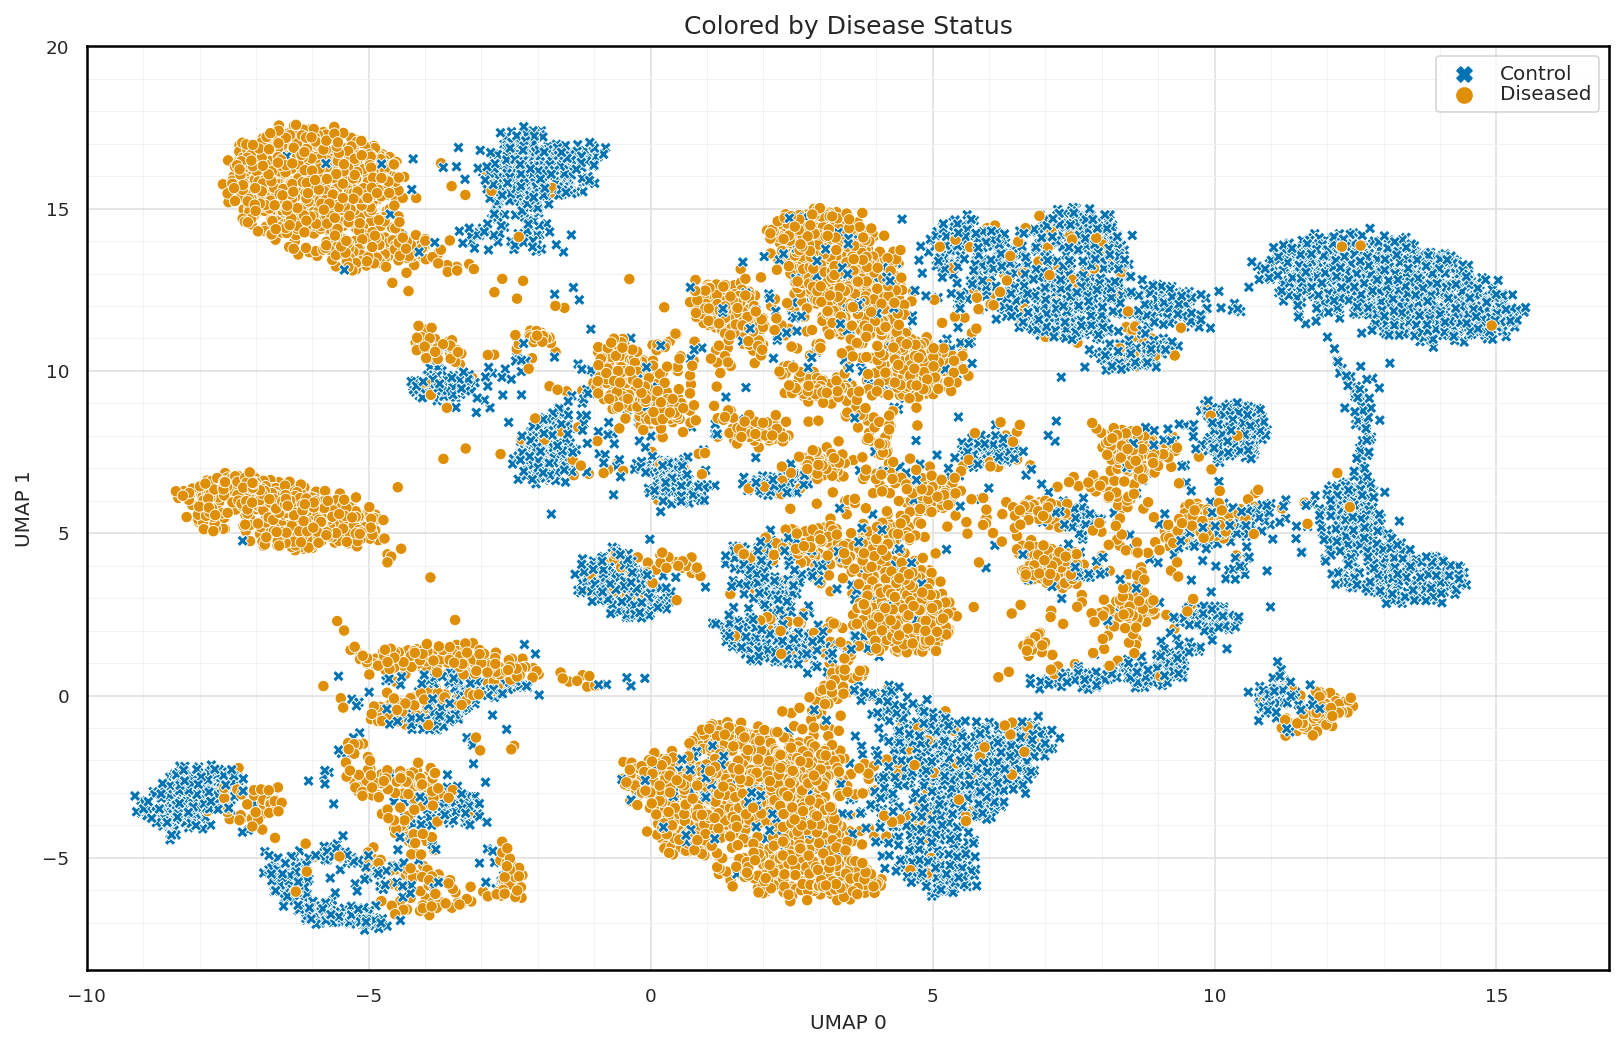

In [ ]:
sns.set_style("whitegrid")
sns.set_style("whitegrid", {
    "grid.color": "#e0e0e0",    # Very light gray grid lines
    "grid.linewidth": 0.3         # Thinner grid lines
})

# One of "label_status", "label_category", 'label_body_site', 'label_country', or 'label_composite'.
plot_target = 'label_status'

color_col = plot_target
sorted_labels = sorted(df_embeddings[color_col].unique())
mapping_by_label = {item:i for i, item in enumerate(sorted_labels)}
map_len = len(mapping_by_label)

plt.figure(figsize=(14,8))

plt.xlabel('UMAP 0')
plt.ylabel('UMAP 1')

plt.xlim(-10, 17)

plt.title(f'Colored by Disease Status', fontsize=12)

palette = sns.color_palette('colorblind', n_colors=map_len)
ax = sns.scatterplot(x=embedding[:, 0],
                     y=embedding[:, 1],
                     s=30,
                     hue=df_embeddings[color_col],
                     style=df_embeddings[color_col],
                     palette=palette,
                     legend=True,
                     hue_order=sorted_labels)

# Margin
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

# Set minor tick locations at every 2.5
ax.set_xticks(np.arange(-10, 16, 1), minor=True)
ax.set_yticks(np.arange(-7, 21, 1), minor=True)

# # Add minor grid lines with lighter gray
ax.grid(which='minor', color='#f0f0f0', linestyle='-', linewidth=0.4)
ax.grid(which='major', color='#e0e0e0', linestyle='-', linewidth=0.8)

# Position legend outside plot area for better readability with N classes
if plot_target == 'label_status':
    legend = ax.legend(loc='upper right', labelspacing=0.08, fontsize='medium',
                       markerscale=1.5)
else:
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                       handletextpad=-0.1, borderpad=0.8, labelspacing=0.55,
                       fontsize='large', markerscale=1.5)

# Title-case the legend labels
for text in legend.get_texts():
    text.set_text(text.get_text().title())  # Title-case the legend text

# Adjust legend size to match the plot height
ax.set_aspect('auto', adjustable='box')  # Ensures the plot can adjust

# Set the legend height and width
fig = plt.gcf()

# Increase right margin for n-class legend
fig.subplots_adjust(right=0.85)

plt.show()

## Greyed Out

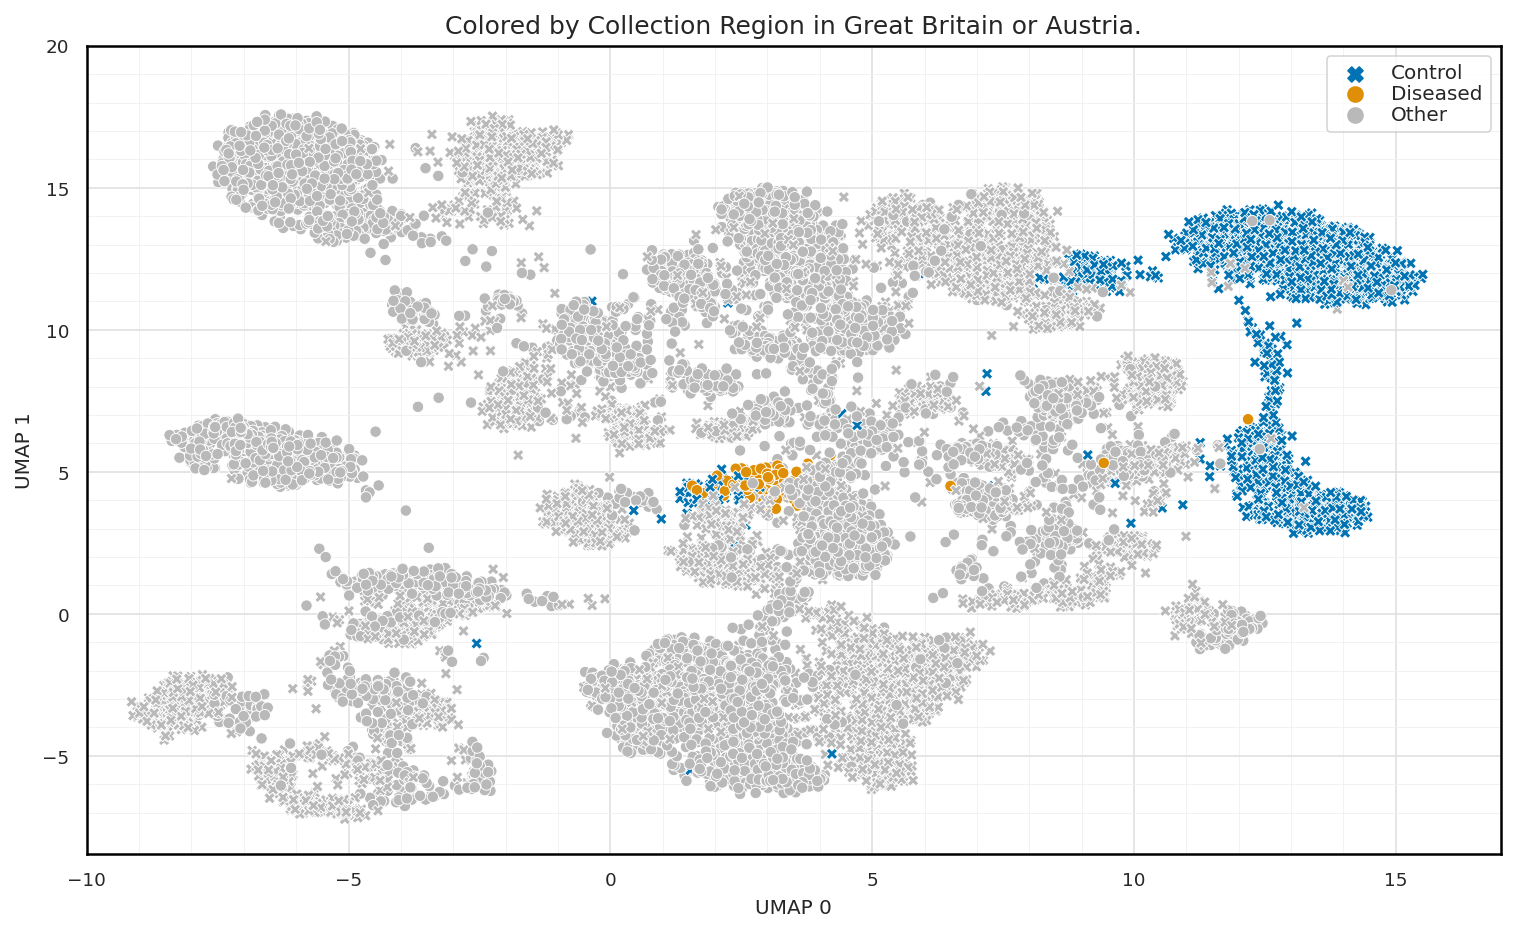

In [183]:
sns.set_style("whitegrid")
sns.set_style("whitegrid", {
    "grid.color": "#e0e0e0",    # Very light gray grid lines
    "grid.linewidth": 0.3         # Thinner grid lines
})

# One of "label_status", "label_category", 'label_body_site', 'label_country', or 'label_composite'.
plot_target = 'label_status'

color_col = plot_target
sorted_labels = sorted(df_embeddings[color_col].unique())
mapping_by_label = {item:i for i, item in enumerate(sorted_labels)}
map_len = len(mapping_by_label)

plt.figure(figsize=(13,7))

plt.xlabel('UMAP 0')
plt.ylabel('UMAP 1')

plt.xlim(-10, 17)

plt.title(f'Colored by Collection Region in Great Britain or Austria.', fontsize=12)

palette = sns.color_palette('colorblind', n_colors=map_len)
category_mask = (
    (df_embeddings['label_country'] == 'Great Britain') |
    (df_embeddings['label_country'] == 'Austria') |
    (df_embeddings['label_category'] == 'healthy subject study')
)
color_values = df_embeddings[color_col].copy()
color_values[~category_mask] = 'other'
palette_extended = palette + ["#b9b9b9"]
sorted_labels_extended = sorted_labels + ['other']

ax = sns.scatterplot(x=embedding[:, 0],
                     y=embedding[:, 1],
                     s=30,
                     hue=color_values,
                     style=df_embeddings[color_col],
                     palette=palette_extended,
                     legend=True,
                     hue_order=sorted_labels_extended)

# Margin
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

# Set minor tick locations at every 2.5
ax.set_xticks(np.arange(-10, 16, 1), minor=True)
ax.set_yticks(np.arange(-7, 21, 1), minor=True)
# # Add minor grid lines with lighter gray
ax.grid(which='minor', color='#f0f0f0', linestyle='-', linewidth=0.4)
ax.grid(which='major', color='#e0e0e0', linestyle='-', linewidth=0.8)

# Position legend outside plot area for better readability with N classes
if plot_target == 'label_status':
    legend = ax.legend(loc='upper right', labelspacing=0.08, fontsize='medium',
                       markerscale=1.5)
else:
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                       handletextpad=-0.1, borderpad=0.8, labelspacing=0.55,
                       fontsize='large', markerscale=1.5)

# Title-case the legend labels
for text in legend.get_texts():
    text.set_text(text.get_text().capitalize())

# Adjust legend size to match the plot height
ax.set_aspect('auto', adjustable='box')  # Ensures the plot can adjust

# Set the legend height and width
fig = plt.gcf()
# Increase right margin for n-class legend
fig.subplots_adjust(right=0.85)

plt.show()

## Disease Type & Geographic Location
These plots have a different size and aspect-ratio to accomodate the figure in the paper.

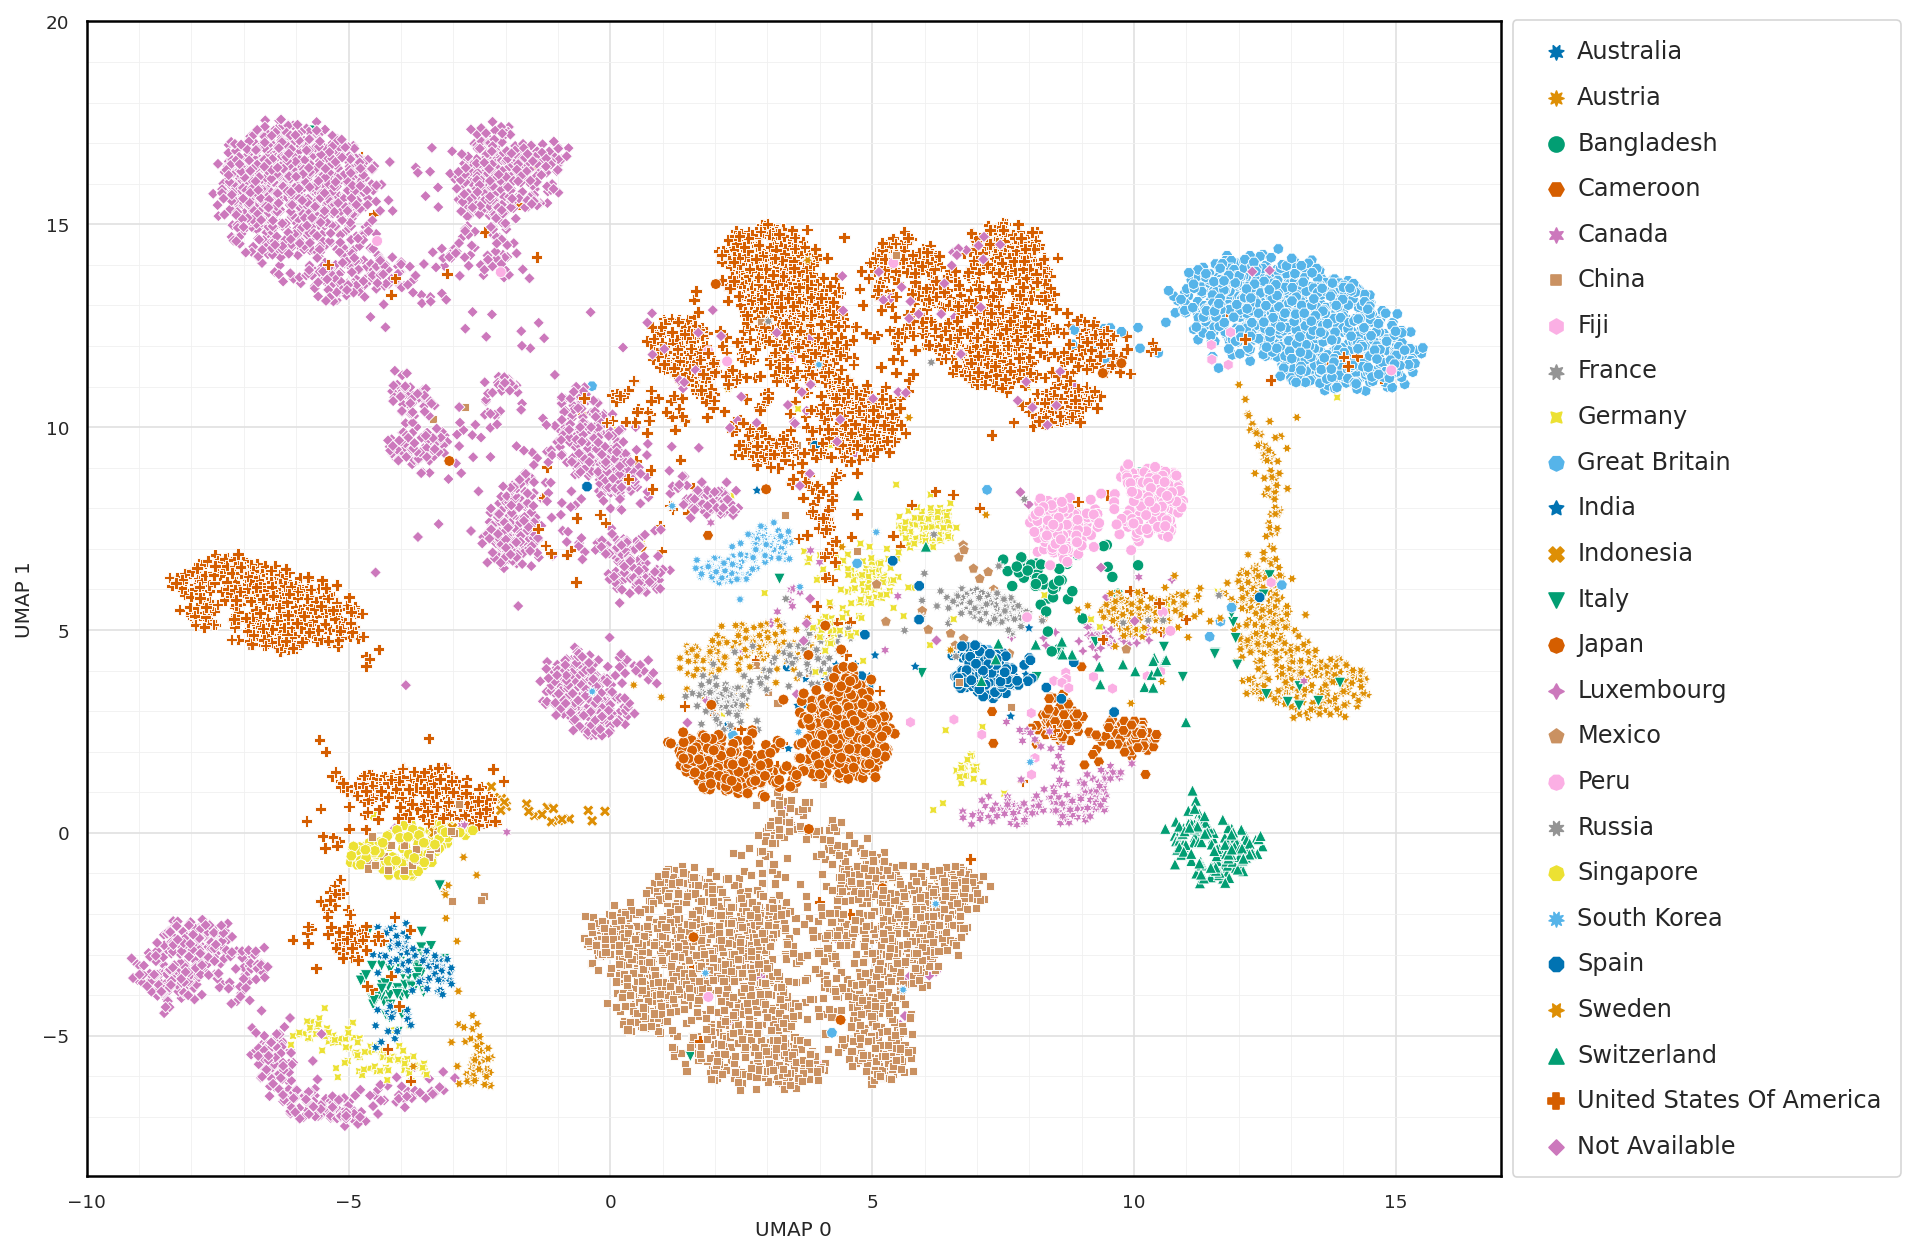

In [175]:
sns.set_style("whitegrid")
sns.set_style("whitegrid", {
    "grid.color": "#e0e0e0",    # Very light gray grid lines
    "grid.linewidth": 0.3         # Thinner grid lines
})

# One of "label_status", "label_category", 'label_body_site', 'label_country', or 'label_composite'.
plot_target = 'label_country'

color_col = plot_target
sorted_labels = sorted(df_embeddings[color_col].unique())
mapping_by_label = {item:i for i, item in enumerate(sorted_labels)}
map_len = len(mapping_by_label)

plt.figure(figsize=(13,10))
# Increase resolution while keeping same dimensions
# plt.rcParams['figure.dpi'] = 150

plt.xlabel('UMAP 0')
plt.ylabel('UMAP 1')

plt.xlim(-10, 17)
# plt.ylim(-7, 20)

# plt.title(f'Colored by {color_col.replace("label_", " ").title()}', fontsize=12)

palette = sns.color_palette('colorblind', n_colors=map_len)
ax = sns.scatterplot(x=embedding[:, 0],
                     y=embedding[:, 1],
                     s=30,
                     hue=df_embeddings[color_col],
                     style=df_embeddings[color_col],
                     palette=palette,
                     legend=True,
                     hue_order=sorted_labels)

# Margin
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

# Set minor tick locations at every 2.5
ax.set_xticks(np.arange(-10, 16, 1), minor=True)
ax.set_yticks(np.arange(-7, 21, 1), minor=True)
# # Add minor grid lines with lighter gray
ax.grid(which='minor', color='#f0f0f0', linestyle='-', linewidth=0.4)
ax.grid(which='major', color='#e0e0e0', linestyle='-', linewidth=0.8)

# Position legend outside plot area for better readability with N classes
if plot_target == 'label_status':
    legend = ax.legend(loc='upper right', labelspacing=0.08, fontsize='medium',
                       markerscale=1.5)
else:
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                       handletextpad=-0.1, borderpad=0.8, labelspacing=0.9,
                       fontsize='large', markerscale=1.5)

# Title-case the legend labels
for text in legend.get_texts():
    text.set_text(text.get_text().title())  # Title-case the legend text

# Adjust legend size to match the plot height
ax.set_aspect('auto', adjustable='box')  # Ensures the plot can adjust

# Set the legend height and width
fig = plt.gcf()
# Increase right margin for n-class legend
fig.subplots_adjust(right=0.85)

plt.show()